In [74]:
%gui qt
%matplotlib notebook

import pandas as pd
import numpy as np
import scipy
from scipy import stats
import matplotlib.pyplot as plt
import matplotlib.colors as colors
import matplotlib.cm as cmx
#import scipy.interpolate as spi
import pickle

import numpy as np
from numpy import linalg as LA

from filters import butter_lowpass_lfilter, butter_highpass_lfilter
from pykalman import KalmanFilter
import peakdet
import KF

fs = 25
rot_speed = input('Enter rotataional speed of stim (rpm): ')
rot_speed *= 6

Enter rotataional speed of stim (rpm): 0.5


## Open saved data (pickle)

In [75]:

import cpd
#If you want to open a file from another folder, create a new cell, type "cd" then "cd/FOLDER/FOLDER" to change the 
#working directory to the folder that contains your file.

filename = '94_.5rpm2_processed.p'
raw_pd = pd.read_pickle(filename)

raw_mat = raw_pd.as_matrix()
rot_dir=raw_mat.T[:9][0]
raw_mat = raw_mat.T[:9]
raw_mat = raw_mat.T
raw_mat = raw_mat.astype(np.float)

rot_speed = input('Enter rotataional speed of stim (rpm): ')
rot_speed *= 6

Enter rotataional speed of stim (rpm): 0.5


array([ -5.94775640e+00,   1.11892937e+01,  -2.01739376e-03,
        -2.56904673e+00,  -8.01562054e+00,   8.97010614e+00,
        -5.44087197e-03,  -2.58407333e+00,   3.83000000e+02])

# Create vectors from points

In [76]:
vectors = []
vector_mag = []
slopes = []
midpt = []

vectors = (raw_mat[:,4]-raw_mat[:,0],raw_mat[:,5]-raw_mat[:,1])
#vectors = (yellow_mat[:,0]-red_mat[:,0],yellow_mat[:,1]-red_mat[:,1])
vector_mag = np.sqrt(vectors[0]**2 + vectors[1]**2)
slopes = vectors[1]/vectors[0]

for i in range(len(vectors[0])):
    #midpt.append(([red_mat[i,0]+vectors[0][i]/2,red_mat[i,1]+vectors[1][i]/2]))
    midpt.append(([raw_mat[i,0]+vectors[0][i]/2,raw_mat[i,1]+vectors[1][i]/2]))

mid_KF = KF.KFilt(np.array(midpt)) 
#mid_KF = np.column_stack((mid_KF[0][:,0],mid_KF[1][:,0],mid_KF[0][:,1],mid_KF[1][:,1],frames))
mid_mag = np.sqrt(mid_KF[0][:,0]**2 + mid_KF[0][:,1]**2)

# Head angle and angular velocity

In [81]:
fs = 25
frames = raw_mat[:,8]
T = frames/25.

#get angle from horizontal, in degrees
global theta
theta = np.unwrap(np.arctan2(vectors[1],vectors[0]))
theta_deg = theta*180/(2*np.pi)

#smooth angular velocity
w = np.diff(theta_deg)*fs

#lowpass filter to smooth (2/3: not necessary to smooth)
w_smooth = butter_lowpass_lfilter(w,1.5,fs=25)

<IPython.core.display.Javascript object>


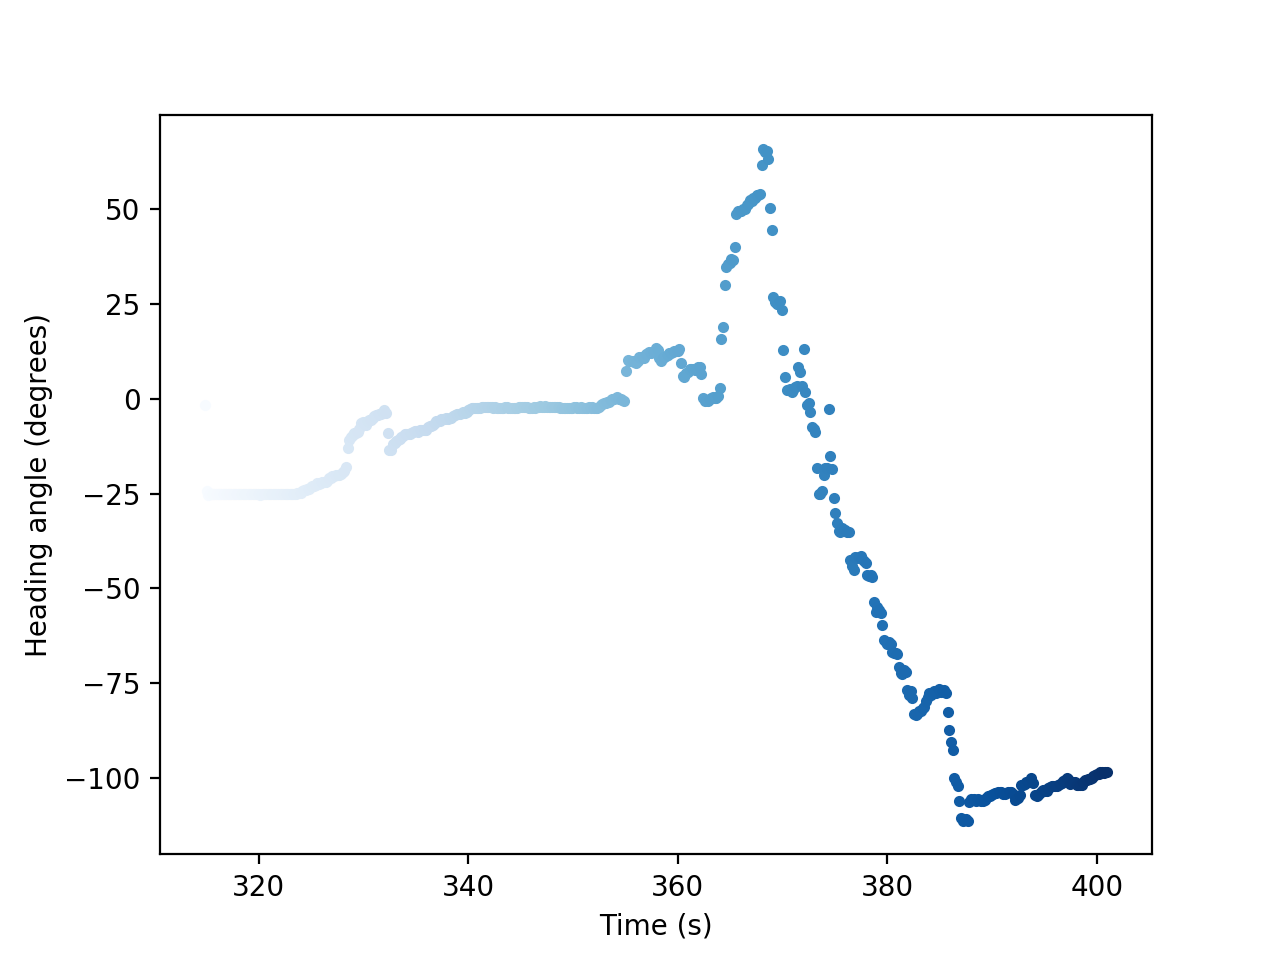

In [82]:
plt.figure()
for i in range(0,len(theta),4):
    colorVal = scalarMap.to_rgba(i)
    plt.plot(T[i],theta_deg[i],'.',color=colorVal)#plt.plot(T[1:],w_smooth,'k')
#for i in range(0,len(w),4):
#    colorVal = scalarMap.to_rgba(i)
#    plt.plot(T[i],w_smooth[i],'.',color=colorVal)
plt.ylabel('Heading angle (degrees)')
plt.xlabel('Time (s)')
plt.show()

<IPython.core.display.Javascript object>


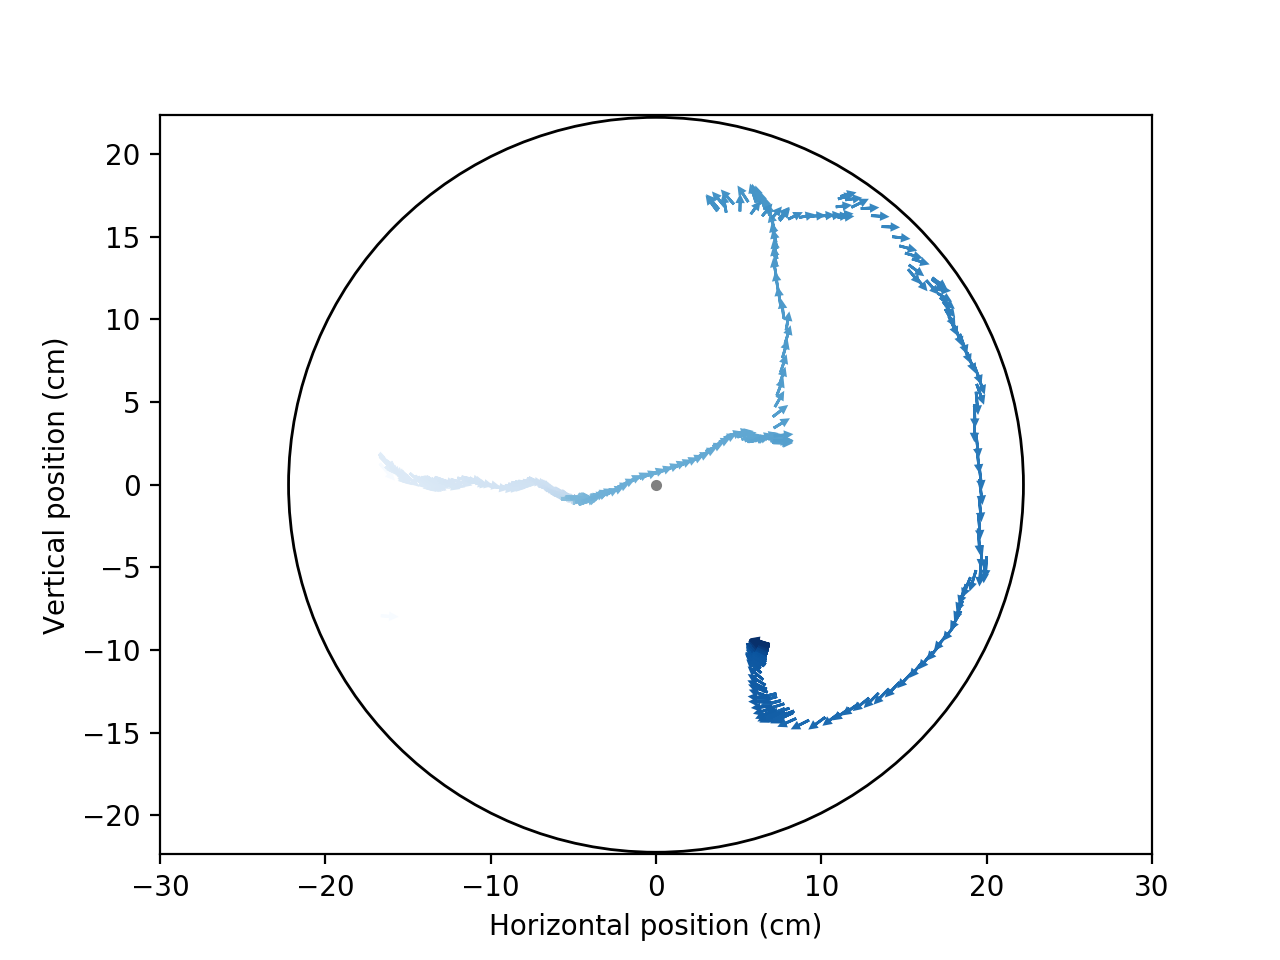

In [83]:
#plot vectors
#cmap = plt.cm.autumn
cmap = plt.cm.Blues
cNorm  = colors.Normalize(vmin=0, vmax=len(vectors[0]))#np.min(DATA[:,4]), vmax=np.max(DATA[:,4]))
#cNorm  = colors.Normalize(vmin=np.min(u_theta), vmax=np.max(u_theta))
scalarMap = cmx.ScalarMappable(norm=cNorm,cmap=cmap)
a = [i[0] for i in sorted(enumerate(theta_deg), key=lambda x:x[1])]

plt.figure()
ax = plt.axes()

for i in range(0,len(vectors[0]),4):
	colorVal = scalarMap.to_rgba(i)#a[i]
	ax.arrow(raw_mat[i,0],raw_mat[i,1],vectors[0][i],vectors[1][i], color=colorVal,head_length=0.3, head_width=0.3)

circ1 = plt.Circle((0,0),44.45/2,color='k',fill=False)
ax.add_artist(circ1)
plt.plot(0,0,'.',color='gray')
plt.axis('equal')
plt.xlim((-30,30))
plt.ylim((-30,30))
plt.xlabel('Horizontal position (cm)')
plt.ylabel('Vertical position (cm)')
plt.show()

# Nystagmus detection

In [104]:
#Find peaks, min and max
dp = 30 # distance between peaks
if rot_speed > dp:
    dp = rot_speed-10
peaks = peakdet.peakdet(w,dp)

maxes = peaks[0].T[0].astype(int)
mins = peaks[1].T[0].astype(int)

#locations = mins
#TODO: fix this!
#CW = np.where(T[mins]<410)
#CCW = np.where(T[mins]>410)
locations = input('Use min or max peaks? ')
if locations.lower =='min':
    locations = mins
elif locations.lower == 'max':
    locations = maxes
#locations = list(mins[CW])+list(mins[CCW])
#locations

#TODO: change with rotation direction
#maxes == CCW
#mins == CW

slopes = []
gains = []
angvel = []
nyst_time=[]
nyst_bool = np.zeros(np.size(theta_deg),dtype=bool)

for i in range(2,len(locations)):
    if i > 2:
        start = int(locations[i-1])+5
        end = int(locations[i])-4
        length = end-start
        print(T[start],length)
        if start>=end or length<6:
            continue
        elif length > 150:
            print(T[start])
            end = start+60#int(maxes[i-1])+300
        nyst_bool[start:end]=True
        linfit = scipy.stats.linregress(T[start:end],theta_deg[start:end]) 
        slopes.append(linfit.slope)
        angvel.append(np.mean(w[start:end]))
        #if np.abs(linfit.slope/rot_speed) < 2:
        gains.append(linfit.slope/rot_speed)
        nyst_time.append(T[int(start)])
            
mean_gain = np.nanmean(np.abs(gains))
mean_ang_gain = np.nanmean(np.abs(angvel))/rot_speed
if not np.all(nyst_bool==False):
    a = np.linspace(nyst_time[0],T[-1])

    plt.figure()
    plt.subplot(211)
    #plt.plot(subset_T,subset)
    plt.plot(T,theta_deg)
    for i in range(len(locations)):
        if i > 2:
            plt.plot(T[int(locations[i-1])+5],theta_deg[int(locations[i-1])+5],'g+') #start of fit region
            plt.plot(T[int(locations[i])-4],theta_deg[int(locations[i]-4)],'r+') #end of fit region, T[int(locations[i])-4]
    plt.xlim((T[0],T[-1]+20))
    
    plt.subplot(212)
    plt.plot(nyst_time,np.abs(gains),'.-', label='Gain from $\Theta$')
    #plt.plot(np.abs(angvel)/6,'.-',label='Gain from $\omega$')
    plt.errorbar(a[0]-1,np.mean(np.abs(gains[:-1])),\
                 yerr=np.std(np.abs(gains[:-1]))/len(gains[:-1]),\
                 fmt='bo',label='Mean = {:.3}'.format(mean_gain))
    plt.errorbar(a[0]-1,np.mean(np.abs(angvel)/6),\
                 yerr=np.std(np.abs(angvel)/6),\
                 fmt='ro',label='Mean = {}'.format(mean_ang_gain))

    plt.plot(a,np.ones(np.size(a)),'k:')
    plt.xlim((T[0],T[-1]+20))
    plt.ylabel("Absolute value gain ($\omega_h/ \omega_s$)")
    plt.xlabel('Time (s)')

    #plt.title('Calculating gain between nystagmus events')
    plt.legend()
    plt.show()
else:
    print("No nystagmus events found")


Use min or max peaks? 'min'
No nystagmus events found


/anaconda/lib/python2.7/site-packages/ipykernel/__main__.py:51: RuntimeWarning: Mean of empty slice
/anaconda/lib/python2.7/site-packages/ipykernel/__main__.py:52: RuntimeWarning: Mean of empty slice


<IPython.core.display.Javascript object>


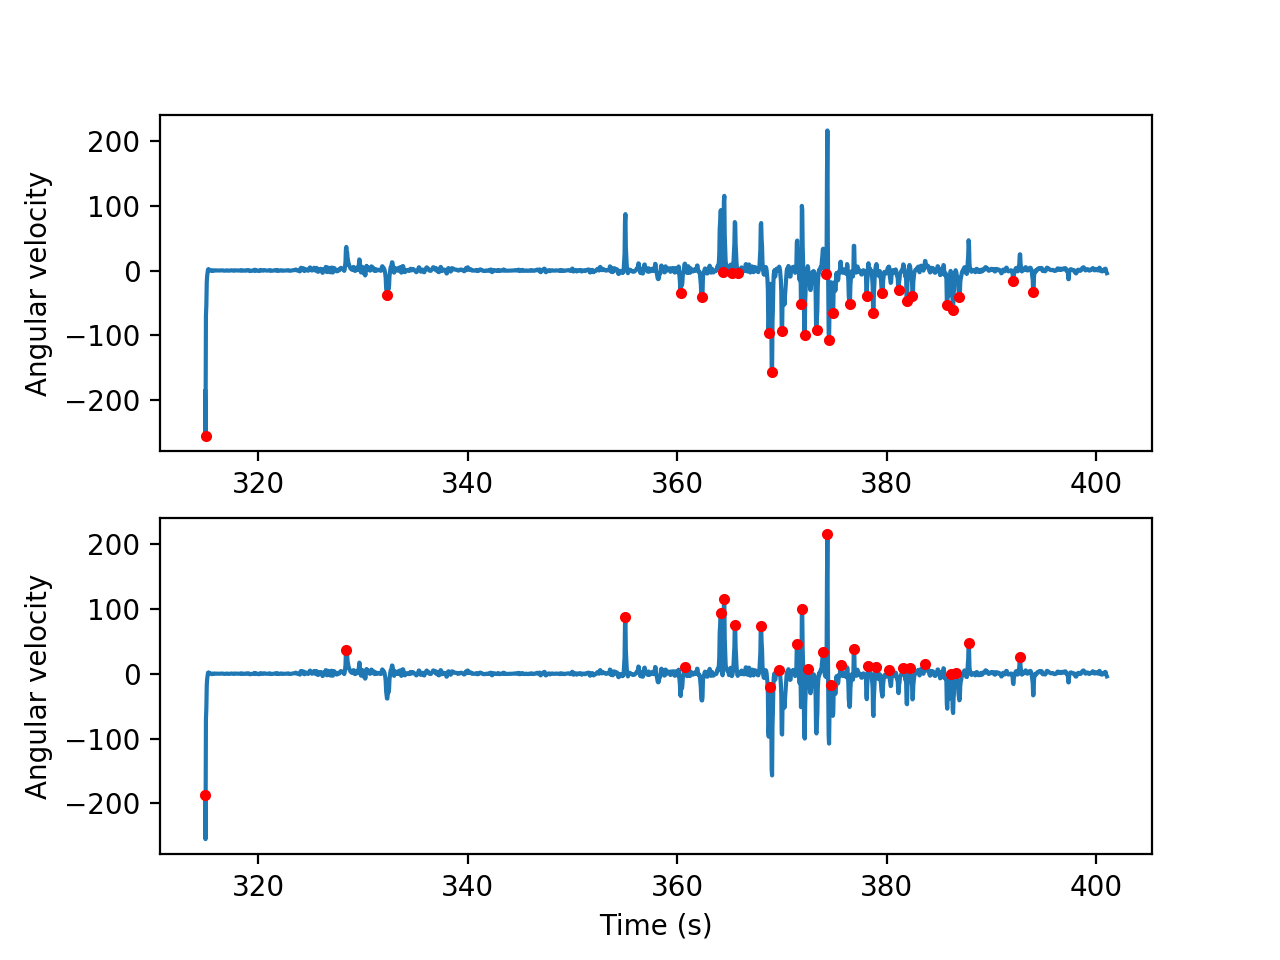

In [99]:
plt.figure()
plt.subplot(211)
plt.plot(T[1:],w)
for i in range(len(mins)):
    plt.plot(T[mins[i]+1],w[mins[i]],'r.')
plt.ylabel('Angular velocity')

plt.subplot(212)
plt.plot(T[1:],w)
for i in range(len(maxes)):
    plt.plot(T[maxes[i]+1],w[maxes[i]],'r.')
plt.ylabel('Angular velocity')
plt.xlabel('Time (s)')
plt.show()

# CPD (slow)

In [87]:
grating = input('Enter grating size (in): ') #1./20
grating = [grating *2.54]    #get grating distance in cm
global grating
per = 2*grating    #calculate period
diam = 44.45  #diameter in cm

x,y = cpd.make_circ(diam/2)
circle = cpd.Polygon(zip(x,y))
dt = np.linspace(0.01,44.45,800)

#cpd,view_dist = cpd.calc_view_dist(yellow_mat[:,:2],vector_mag)
cpd,view_dist = cpd.calc_view_dist(raw_mat[:,4:6],vector_mag,circle,theta,grating,dt)


Enter grating size (in): 1./20


# Headwag detection

<IPython.core.display.Javascript object>


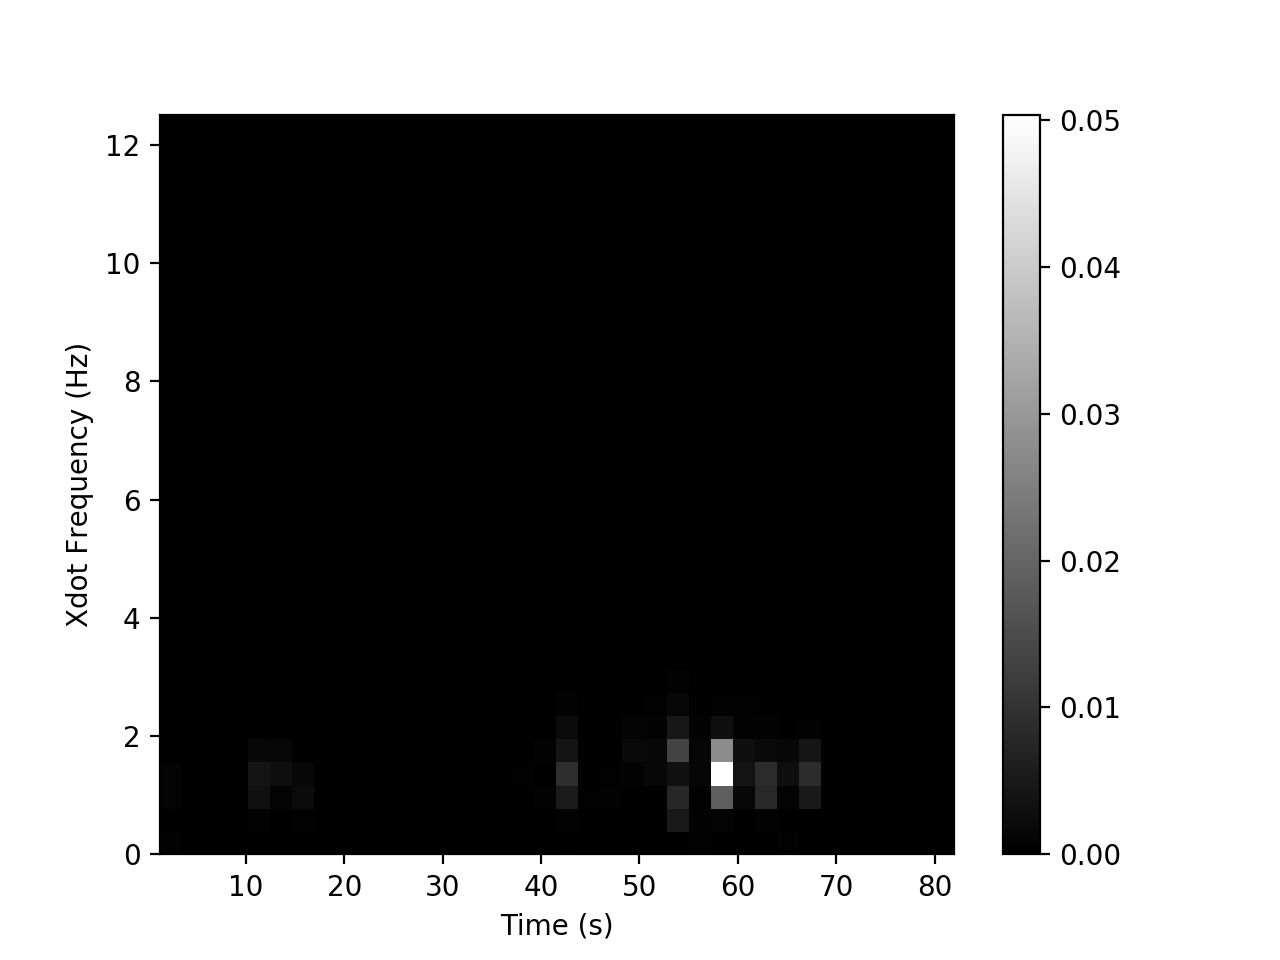

In [88]:
N = len(raw_mat) #number samples

HPF_mid = butter_highpass_lfilter(mid_mag,1,25)

#make window
Nx = 64 #TODO: NFFT of sample length
win = scipy.signal.get_window('hann',Nx=Nx)

#start 50 timesteps out to get rid of onset ringing
f_x, t_x, S_x = scipy.signal.spectrogram(HPF_mid[50:],fs,window=win,nperseg=Nx)#red_mat[:,2],fs) #x velocity

#plotting
plt.figure()
plt.pcolormesh(t_x, f_x, S_x, cmap='gray')
plt.colorbar()
#plt.ylim((0,6))
plt.ylabel('Xdot Frequency (Hz)')
plt.xlabel('Time (s)')

thresh = next(x[0] for x in enumerate(f_x) if x[1] > 0)
s_dt = np.diff(t_x)[0]   #timestep of spectrogram
dt_frames = np.int(np.round(s_dt*25))
dt = np.diff(t_x)[0]*25

#frame number where headwagging occurs
head_wag = []
head_wag_idx = []
for i in range(S_x.shape[1]-1):
    if max(S_x[thresh:,i])>=0.0001:
        head_wag.append(np.round((t_x.T[i]+T[0]+s_dt*1.5)))

#get indices where head wagging is detected
for i in range(len(head_wag)):
    head_wag_idx.append(np.where(np.round(T,2)==head_wag[i])[0][0])  #+T[0] deals with time offset between realtime and spectrogram time

hw_events = []
hw_cpd = []
hw_vd = []
head_wag_idx=[]
hw_bool = np.zeros(np.size(raw_mat[:,0]), dtype=bool)

#TODO: get rid of hw_events. ultimately only have hw_bool, 
#TODO: make separate cell for hw_cpd, hw_vd
#for i in range(len(head_wag_idx)-1):
for row in head_wag_idx:
    if row+dt_frames<len(raw_mat[:,0]):
        hw_events.append(raw_mat[row:row+dt_frames,0])
        hw_bool[row:row+dt_frames]=True
    else:
        hw_events.append(raw_mat[row:,0])
        hw_bool[row:]=True
   
    hw_cpd.append(cpd[row:row+dt_frames])
    hw_vd.append(view_dist[row:row+dt_frames])

#mean_stats = get_hw_stats(hw_events,hw_cpd)
#hw_data = pd.DataFrame({'head_wag':hw_events,'cpd':hw_cpd,'vd':hw_vd})


<IPython.core.display.Javascript object>


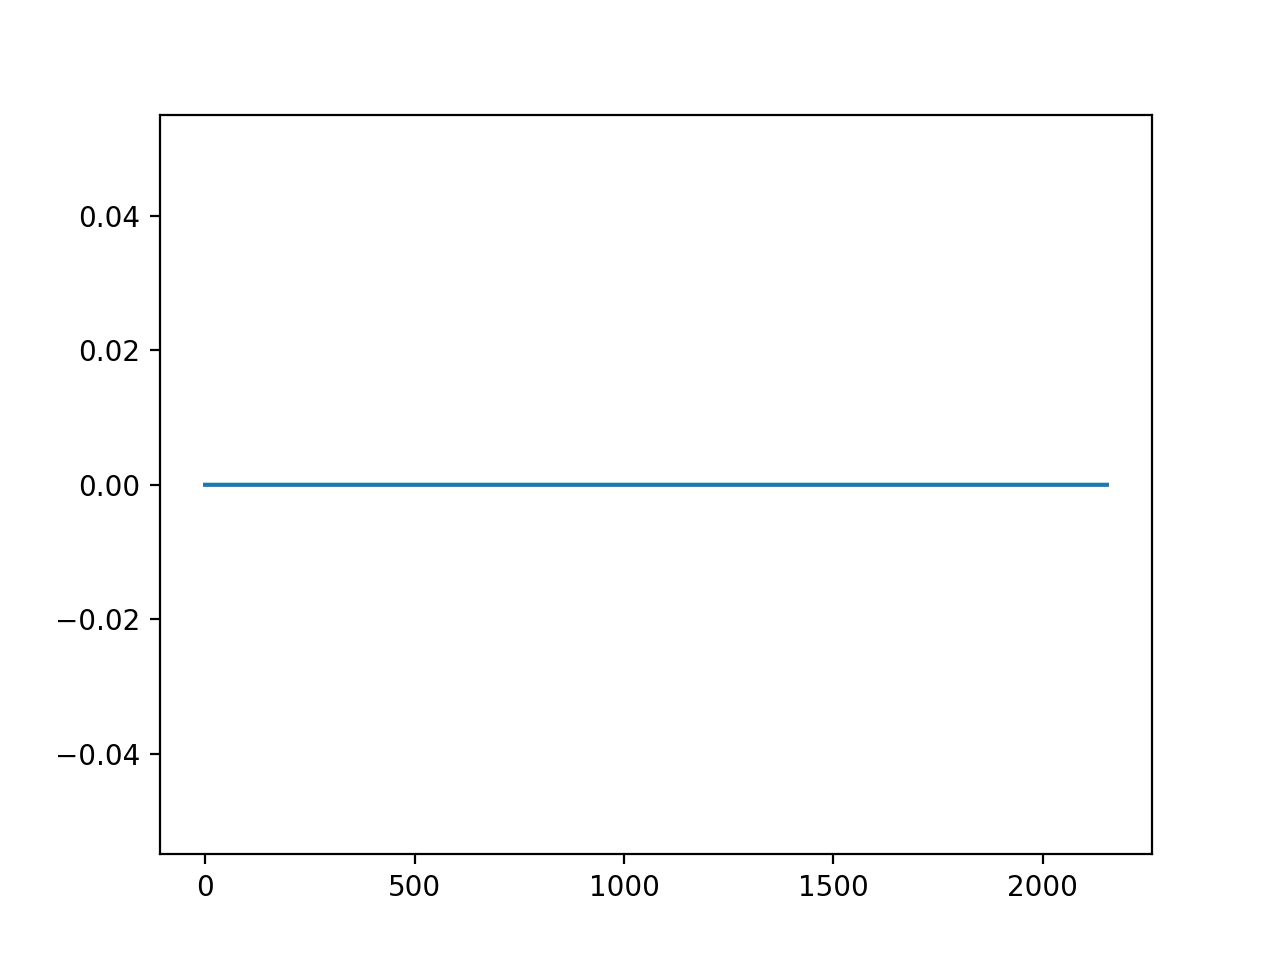

False

In [103]:
plt.figure()
plt.plot(HPF_mid)
plt.show()
np.any(hw_bool==True)

# Save data (pickle)

In [93]:
processed_data = np.column_stack((frames,raw_mat[:,:8],vectors[0],vectors[1],\
                                  vector_mag,theta,view_dist,cpd,nyst_bool,hw_bool))

processed_pd = pd.DataFrame(processed_data,
                      columns = ['frames','red_x','red_y','red x vel','red y vel','yellow_x',\
                                 'yellow_y','yellow x vel','yellow y vel','vector_dx','vector_dy',\
                                'vector_mag','theta','view dist','cpd','nyst_bool','hw_bool'])
savename = filename[:len(filename)-5]+'processed.p'
print('Savename will be {}'.format(savename))
nameOK = input('Continue with savename? (Y/n) ')

if np.strmatch('n'):
    savename = input('Enter savename, complete with extentsion: ')

processed_pd.to_pickle(savename)
print('Data saved to {}'.format(savename))
#processed_pd.to_pickle('94_0.5rpm1_processed.p')

Data saved to 94_.5rpm2_procesprocessed.p
